In [ ]:
OPENAI_API_KEY=''
GOOGLE_PALM_API_KEY=''

In [ ]:
from dotenv import load_dotenv
from pathlib import Path

def load_secets():
    load_dotenv()
    env_path = Path(".") / ".env"
    load_dotenv(dotenv_path=env_path)

    open_ai_key = os.getenv("OPENAI_API_KEY")
    google_palm_key = os.getenv("GOOGLE_PALM_API_KEY")

    return {
        "OPENAI_API_KEY": open_ai_key,
        "GOOGLE_PALM_API_KEY": google_palm_key,
    }

In [ ]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

class Validation(BaseModel):
    plan_is_valid: str = Field(
        description="This field is 'yes' if the plan is feasible, 'no' otherwise"
    )
    updated_request: str = Field(description="Your update to the plan")


class ValidationTemplate(object):
    def __init__(self):
        self.system_template = """
      You are a travel agent who helps users make exciting travel plans.

      The user's request will be denoted by four hashtags. Determine if the user's
      request is reasonable and achievable within the constraints they set.

      A valid request should contain the following:
      - A start and end location
      - A trip duration that is reasonable given the start and end location
      -Trip safer path and also the places to visit in the path from the start location to end location

      Any request that contains potentially harmful activities is not valid, regardless of what
      other details are provided.

      If the request is not valid, set
      plan_is_valid = 0 and use your travel expertise to update the request to make it valid,
      keeping your revised request shorter than 100 words.

      If the request seems reasonable, then set plan_is_valid = 1 and
      don't revise the request.

      {format_instructions}
    """

        self.human_template = """
      ####{query}####
    """

        self.parser = PydanticOutputParser(pydantic_object=Validation)

        self.system_message_prompt = SystemMessagePromptTemplate.from_template(
            self.system_template,
            partial_variables={
                "format_instructions": self.parser.get_format_instructions()
            },
        )
        self.human_message_prompt = HumanMessagePromptTemplate.from_template(
            self.human_template, input_variables=["query"]
        )

        self.chat_prompt = ChatPromptTemplate.from_messages(
            [self.system_message_prompt, self.human_message_prompt]
        )

In [ ]:
# prompt: CHANGE THE ABOVE FORMAT INSTRUCTIONS TO DISPLAY ANSWER

class ValidationTemplate(object):
    def __init__(self):
        self.system_template = """
      You are a travel agent who helps users make exciting travel plans.

      The user's request will be denoted by four hashtags. Determine if the user's
      request is reasonable and achievable within the constraints they set.

      A valid request should contain the following:
      - A start and end location
      - A trip duration that is reasonable given the start and end location
      - Some other details, like the user's interests and/or preferred mode of transport

      Any request that contains potentially harmful activities is not valid, regardless of what
      other details are provided.

      If the request is not valid, set
      plan_is_valid = 0 and use your travel expertise to update the request to make it valid,
      keeping your revised request shorter than 100 words.

      If the request seems reasonable, then set plan_is_valid = 1 and
      don't revise the request.

      {format_instructions}
    """

        self.human_template = """
      ####{query}####
    """

        self.parser = PydanticOutputParser(pydantic_object=Validation)

        self.system_message_prompt = SystemMessagePromptTemplate.from_template(
            self.system_template,
            partial_variables={
                "format_instructions": self.parser.get_format_instructions(
                    display_name="Validation",
                    show_examples=True,
                    max_examples=1,
                )
            },
        )
        self.human_message_prompt = HumanMessagePromptTemplate.from_template(
            self.human_template, input_variables=["query"]
        )

        self.chat_prompt = ChatPromptTemplate.from_messages(
            [self.system_message_prompt, self.human_message_prompt]
        )


In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
import openai
import logging
import time
# for Palm
from langchain.llms import GooglePalm
# for OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, SequentialChain

logging.basicConfig(level=logging.INFO)

class Agent(object):
    def __init__(
        self,
        open_ai_api_key,
        model="gpt-3.5-turbo",
        temperature=0,
        debug=True,
    ):
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)
        self._openai_key = open_ai_api_key

        self.chat_model = ChatOpenAI(model=model, temperature=temperature, openai_api_key=self._openai_key)
        self.validation_prompt = ValidationTemplate()
        self.validation_chain = self._set_up_validation_chain(debug)

    def _set_up_validation_chain(self, debug=True):

        # make validation agent chain
        validation_agent = LLMChain(
            llm=self.chat_model,
            prompt=self.validation_prompt.chat_prompt,
            output_parser=self.validation_prompt.parser,
            output_key="validation_output",
            verbose=debug,
        )

        # add to sequential chain
        overall_chain = SequentialChain(
            chains=[validation_agent],
            input_variables=["query", "format_instructions"],
            output_variables=["validation_output"],
            verbose=debug,
        )

        return overall_chain

    def validate_travel(self, query):
        self.logger.info("Validating query")
        t1 = time.time()
        self.logger.info(
            "Calling validation (model is {}) on user input".format(
                self.chat_model.model_name
            )
        )
        validation_result = self.validation_chain(
            {
                "query": query,
                "format_instructions": self.validation_prompt.parser.get_format_instructions(),
            }
        )

        validation_test = validation_result["validation_output"].dict()
        t2 = time.time()
        self.logger.info("Time to validate request: {}".format(round(t2 - t1, 2)))

        return validation_test

In [ ]:
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
secrets = load_secets()
travel_agent = Agent(open_ai_api_key="", debug=True)


query = """
       I want to do a 5 day roadtrip from Munnar  to Kochi in India.
       I want to know the places which i can visit from the start location to end lcoation
        """

travel_agent.validate_travel(query)


INFO:__main__:Validating query
INFO:__main__:Calling validation (model is gpt-3.5-turbo) on user input




> Entering new SequentialChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: 
      You are a travel agent who helps users make exciting travel plans.

      The user's request will be denoted by four hashtags. Determine if the user's
      request is reasonable and achievable within the constraints they set.

      A valid request should contain the following:
      - A start and end location
      - A trip duration that is reasonable given the start and end location
      -Trip safer path and also the places to visit in the path from the start location to end location

      Any request that contains potentially harmful activities is not valid, regardless of what
      other details are provided.

      If the request is not valid, set
      plan_is_valid = 0 and use your travel expertise to update the request to make it valid,
      keeping your revised request shorter than 100 words.

      If the request seems reasonable, then set plan_is_valid = 1

INFO:__main__:Time to validate request: 0.83



> Finished chain.

> Finished chain.


{'plan_is_valid': 'yes', 'updated_request': ''}

In [ ]:
# prompt: why the updated request is not displaying the chain answer

# The updated request is not displaying the chain answer because the `validation_test` dictionary does not contain a key called "updated_request".

# To fix this, you need to modify the `Validation` class to include a field for the updated request. For example:

class Validation(BaseModel):
    plan_is_valid: str = Field(
        description="This field is 'yes' if the plan is feasible, 'no' otherwise"
    )
    updated_request: str = Field(description="Your update to the plan", default="")

# Then, you need to modify the `validate_travel` method to set the `updated_request` field in the `validation_result` dictionary. For example:

def validate_travel(self, query):
    self.logger.info("Validating query")
    t1 = time.time()
    self.logger.info(
        "Calling validation (model is {}) on user input".format(
            self.chat_model.model_name
        )
    )
    validation_result = self.validation_chain(
        {
            "query": query,
            "format_instructions": self.validation_prompt.parser.get_format_instructions(),
        }
    )

    validation_test = validation_result["validation_output"].dict()

    # Set the updated request field
    validation_test["updated_request"] = validation_result["validation_output"].updated_request

    t2 = time.time()
    self.logger.info("Time to validate request: {}".format(round(t2 - t1, 2)))

    return validation_test

# Finally, you need to modify the code that prints the updated request to use the new field. For example:



In [ ]:
# prompt: modify the above to code to get updated_request  in proper answer format.Why answer is not getting displayed
h
secrets = load_secets()
travel_agent = Agent(open_ai_api_key="", debug=True)


query = """
       I want to do a 5 day roadtrip from Munnar  to Kochi in India.
       I want to visit the place through mountain views.
        """

validation_test = travel_agent.validate_travel(query)
updated_request = validation_test["updated_request"]

print(f"Updated request: {updated_request}")


INFO:__main__:Validating query
INFO:__main__:Calling validation (model is gpt-3.5-turbo) on user input




> Entering new SequentialChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: 
      You are a travel agent who helps users make exciting travel plans.

      The user's request will be denoted by four hashtags. Determine if the user's
      request is reasonable and achievable within the constraints they set.

      A valid request should contain the following:
      - A start and end location
      - A trip duration that is reasonable given the start and end location
      - Some other details, like the user's interests and/or preferred mode of transport

      Any request that contains potentially harmful activities is not valid, regardless of what
      other details are provided.

      If the request is not valid, set
      plan_is_valid = 0 and use your travel expertise to update the request to make it valid,
      keeping your revised request shorter than 100 words.

      If the request seems reasonable, then set plan_is_valid = 1 and
      don'

INFO:__main__:Time to validate request: 0.92



> Finished chain.

> Finished chain.
Updated request: 


In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import os
!pip install python-dotenv

In [2]:
import pandas as pd

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()


,Timestamp,Main incomer Current R,Main incomer Current Y,Main incomer Current B,Main incomer VOL RY,Main incomer VOL YB,Main incomer VOL BR,Main incomer KW,Main incomer PF
0,01-08-2023 00:00,173.042465,173.933060,182.334091,420.092926,421.757599,422.483429,NaN,85.850424
1,01-08-2023 00:15,136.713852,136.000031,142.112228,422.147919,423.574371,424.100830,NaN,82.693070
2,01-08-2023 00:30,122.184158,120.531586,129.242294,423.314911,424.781525,425.750183,NaN,78.835297
3,01-08-2023 00:45,147.820511,147.056381,154.585083,423.466125,425.228546,425.842743,NaN,81.879675
4,01-08-2023 01:00,169.530563,169.660965,180.001251,424.328369,426.126343,426.804993,NaN,85.423458


epoch:   0 loss: 0.00002704
epoch:  10 loss: 0.00825733
epoch:  20 loss: 0.00476368
epoch:  30 loss: 0.00673416
epoch:  40 loss: 0.01163867
epoch:  50 loss: 0.00373667
epoch:  60 loss: 0.00088729
epoch:  70 loss: 0.00403587
epoch:  80 loss: 0.00665227
epoch:  90 loss: 0.00690967


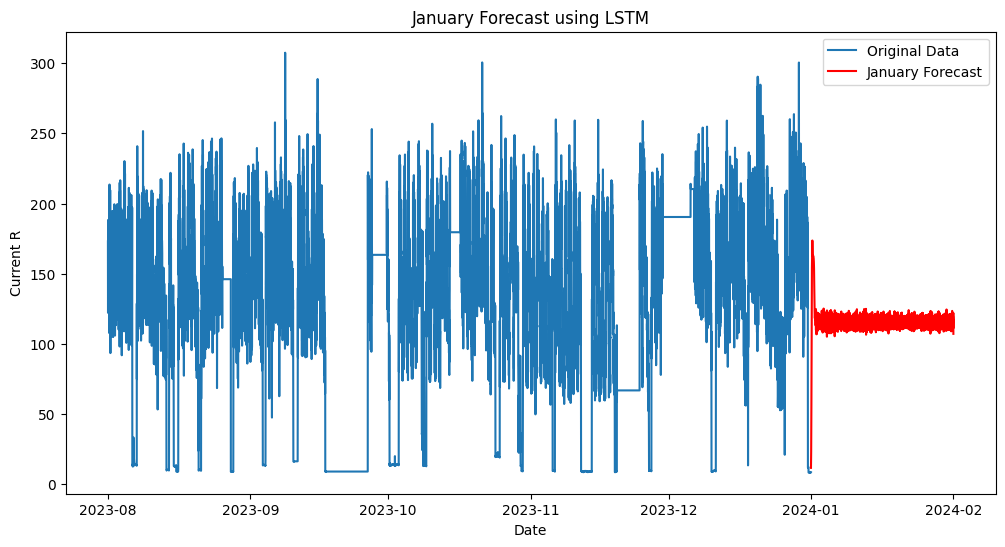

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Using the past 60 time steps to predict the next one
X, y = create_sequences(data_series_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (Variable(torch.zeros(1, 1, self.hidden_layer_size)),
                            Variable(torch.zeros(1, 1, self.hidden_layer_size)))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Initialize the model, loss function, and optimizer
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 100
for epoch in range(epochs):
    for i in range(len(X_train)):
        model.hidden_cell = (Variable(torch.zeros(1, 1, model.hidden_layer_size)),
                             Variable(torch.zeros(1, 1, model.hidden_layer_size)))

        y_pred = model(X_train[i].unsqueeze(0))

        single_loss = loss_function(y_pred, y_train[i].unsqueeze(0))
        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')




model.eval()
test_inputs = data_series_scaled[-seq_length:].tolist()

january_forecast = []
for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(0)
    with torch.no_grad():
        model.hidden_cell = (Variable(torch.zeros(1, 1, model.hidden_layer_size)),
                             Variable(torch.zeros(1, 1, model.hidden_layer_size)))
        january_forecast.append(model(seq).item())
        test_inputs.append([model(seq).item()])

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start=data_series_aug_dec.index[-1], periods=len(january_forecast)+1, freq='15T')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM')
plt.legend()
plt.show()


In [7]:
import os
import openai
import re

# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expression to extract locations from input
    pattern = re.compile(r"FROM\s+(.+?)\s+TO\s+(.+)", re.IGNORECASE)
    match = pattern.search(user_input)
    if match:
        start_location = match.group(1).strip()
        end_location = match.group(2).strip()
        return start_location, end_location
    else:
        return None, None

def generate_route_description(start_location, end_location, vehicle, condition, fuel, companion, men):
    # Prompt for the OpenAI API
    prompt = (f"Given the following details:\n"
              f"Vehicle: {vehicle}\n"
              f"Condition: {condition}\n"
              f"Fuel: {fuel}\n"
              f"Companion: {companion}\n"
              f"Men: {men}\n\n"
              f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances.")

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response['choices'][0]['message']['content'].strip()

# Run the chatbot in a loop
print("Route Description Chatbot. Type 'exit' to quit.")
while True:
    user_input = input("Enter your request: ")
    if user_input.lower() == 'exit':
        print('Exiting')
        break

    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        print("Invalid input format. Please use 'HEY TAKE ME FROM [start location] TO [end location]'.")
        continue

    vehicle = input("Which vehicle are you driving? ")
    condition = input("How's the condition of the vehicle? Well serviced? ")
    fuel = input("How filled is your fuel tank? ")
    companion = input("Who is accompanying you or are you alone? ")
    men = input("Are there any men with you? ")

    route_description = generate_route_description(start_location, end_location, vehicle, condition, fuel, companion, men)
    print("Route Description:", route_description)

    while True:
        satisfied = input("Are you satisfied with this route? (yes/no): ").strip().lower()
        if satisfied == 'yes':
            print("Great! Have a safe journey!")
            break
        elif satisfied == 'no':
            print("Sorry, but that's the only route available.")
            break
        else:
            print("Please answer 'yes' or 'no'.")

Route Description Chatbot. Type 'exit' to quit.


KeyboardInterrupt: Interrupted by user

In [3]:
import os
import openai
import re

# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.getenv("OPENAI_API_KEY")

def extract_locations(user_input):
    # Regular expression to extract locations from input in English or Hindi
    pattern = re.compile(r"(FROM|से)\s+(.+?)\s+(TO|को)\s+(.+)", re.IGNORECASE | re.UNICODE)
    match = pattern.search(user_input)
    if match:
        start_location = match.group(2).strip()
        end_location = match.group(4).strip()
        return start_location, end_location

    return None, None

def get_user_input(prompt, language):
    if language == "en":
        return input(prompt).strip()
    elif language == "hi":
        return input(prompt.encode('utf-8').decode('utf-8')).strip()  # Use Unicode for Hindi input handling
    else:
        raise ValueError("Unsupported language. Please choose 'en' for English or 'hi' for Hindi.")

def generate_route_description(start_location, end_location, vehicle, condition, fuel, companion, men):
    # Prompt for the OpenAI API
    prompt = (f"Given the following details:\n"
              f"Vehicle: {vehicle}\n"
              f"Condition: {condition}\n"
              f"Fuel: {fuel}\n"
              f"Companion: {companion}\n"
              f"Men: {men}\n\n"
              f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances.")

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        language="hi",  # Specify language as Hindi for responses
        max_tokens=150,  # Adjust as needed
        stop=["."]  # Stop generating after a period to form coherent sentences
    )

    return response['choices'][0]['message']['content'].strip()

# Run the chatbot in a loop
print("Route Description Chatbot. Type 'exit' to quit.")
while True:
    user_input = get_user_input("Enter your request (अपनी अनुरोध दर्ज करें): ", "hi")
    if user_input.lower() == 'exit':
        print('Exiting (निकासी)')
        break

    start_location, end_location = extract_locations(user_input)
    if not start_location or not end_location:
        print("Invalid input format. Please use 'HEY TAKE ME FROM [start location] TO [end location]' (अमान्य इनपुट प्रारूप। कृपया 'हेय टेक मे फ्रॉम [शुरूआत स्थान] टू [अंत स्थान]' का उपयोग करें।)")
        continue

    vehicle = get_user_input("Which vehicle are you driving? (आप किस वाहन का उपयोग कर रहे हैं?): ", "hi")
    condition = get_user_input("How's the condition of the vehicle? Well serviced? (वाहन की हालत कैसी है? अच्छी सेवा की गई है?): ", "hi")
    fuel = get_user_input("How filled is your fuel tank? (आपके ईंधन टैंक में कितनी भराई हुई है?): ", "hi")
    companion = get_user_input("Who is accompanying you or are you alone? (आपके साथ कौन है या क्या आप अकेले हैं?): ", "hi")
    men = get_user_input("Are there any men with you? (क्या आपके साथ कोई आदमी हैं?): ", "hi")

    route_description = generate_route_description(start_location, end_location, vehicle, condition, fuel, companion, men)
    print("Route Description (मार्ग विवरण):", route_description)

    while True:
        satisfied = get_user_input("Are you satisfied with this route? (yes/no) (क्या आप इस मार्ग से संतुष्ट हैं?): ", "hi")
        if satisfied == 'yes':
            print("Great! Have a safe journey! (बहुत बढ़िया! सुरक्षित यात्रा करें!)")
            break
        elif satisfied == 'no':
            print("Sorry, but that's the only route available. (माफ़ कीजिए, लेकिन यही मार्ग उपलब्ध है।)")
            break
        else:
            print("Please answer 'yes' or 'no'. (कृपया 'हां' या 'नहीं' का उत्तर दें।)")



Route Description Chatbot. Type 'exit' to quit.
Enter your request (अपनी अनुरोध दर्ज करें): Take me from kannur to kozhikode
Which vehicle are you driving? (आप किस वाहन का उपयोग कर रहे हैं?): BMW
How's the condition of the vehicle? Well serviced? (वाहन की हालत कैसी है? अच्छी सेवा की गई है?): GOOD
How filled is your fuel tank? (आपके ईंधन टैंक में कितनी भराई हुई है?): FULL
Who is accompanying you or are you alone? (आपके साथ कौन है या क्या आप अकेले हैं?): ALONE
Are there any men with you? (क्या आपके साथ कोई आदमी हैं?): YES


InvalidRequestError: Unrecognized request argument supplied: language

In [ ]:
import os
import openai
from IPython.display import HTML, display
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import spacy

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] =
openai.api_key = os.getenv("OPENAI_API_KEY")

# HTML/JavaScript for recording audio in Colab
AUDIO_HTML = """

"""

# Initialize SpaCy model for English
nlp_en = spacy.load("en_core_web_sm")

def translate_text_openai(text, target_language="en"):
    response = openai.Translate(
        model="text-davinci-003",
        inputs={
            "text": text,
            "to_language": target_language
        }
    )
    translated_text = response['translations'][0]['translated_text']
    return translated_text

def translate_audio_to_text(audio_data):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": audio_data}
        ],
        max_tokens=100
    )
    return response.choices[0].message.content.strip()

def extract_locations(user_input):
    # Define keywords that indicate a direction or route request
    direction_keywords = ["from", "to", "take", "route", "drive"]

    # Split user input into words
    words = user_input.lower().split()

    # Initialize variables to store start and end locations
    start_location = None
    end_location = None

    # Iterate over words to find locations
    for i in range(len(words)):
        if words[i] in direction_keywords:
            if i + 1 < len(words):
                if start_location is None:
                    start_location = words[i + 1].capitalize()  # Assuming location is in title case
                elif end_location is None:
                    end_location = words[i + 1].capitalize()  # Assuming location is in title case

    return start_location, end_location

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()

def main():
    print("Route Description Chatbot. Type 'exit' to quit.")
    while True:
        input_type = input("Enter 'text' for text input or 'audio' for audio input: ").strip().lower()

        if input_type == 'exit':
            print('Exiting')
            break

        if input_type not in ['text', 'audio']:
            print("Invalid input type. Please enter 'text' or 'audio'.")
            continue

        if input_type == 'audio':
            display(HTML(AUDIO_HTML))
            data = eval_js("base64data")
            binary = b64decode(data.split(',')[1])

            process = (
                ffmpeg.input('pipe:0')
                .output('pipe:1', format='wav')
                .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True, input=binary)
            )
            output, _ = process.communicate()

            riff_chunk_size = len(output) - 8
            q = riff_chunk_size
            b = []
            for i in range(4):
                q, r = divmod(q, 256)
                b.append(r)

            riff = output[:4] + bytes(b) + output[8:]

            sr, audio = wav_read(io.BytesIO(riff))

            audio_data = translate_audio_to_text(audio.tobytes())
            print("Translated Audio:", audio_data)

            start_location, end_location = extract_locations(audio_data)
            if not start_location or not end_location:
                print("Could not extract start and end locations from input. Please try again.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description:", route_description)

        else:
            user_input = input("Enter your request: ")

            language_code = None
            if ":" in user_input:
                parts = user_input.split(":")
                user_input = parts[0].strip()
                language_code = parts[1].strip().lower()

            if language_code:
                user_input = translate_text_openai(user_input, "en")

            start_location, end_location = extract_locations(user_input)
            if not start_location or not end_location:
                print("Could not extract start and end locations from input. Please try again.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description:", route_description)

if __name__ == "__main__":
    main()

In [3]:
import os
import openai
from IPython.display import HTML, display
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import spacy
from googletrans import Translator

# Set the OpenAI API key (replace with your actual key)
os.environ["OPENAI_API_KEY"] =""
openai.api_key = os.getenv("OPENAI_API_KEY")

# HTML/JavaScript for recording audio in Colab
AUDIO_HTML = """

"""

# Initialize SpaCy models
nlp_en = spacy.load("en_core_web_sm")

# Initialize Google Translator
translator = Translator()

def translate_text_openai(text, target_language="en"):
    response = openai.Translate(
        model="text-davinci-003",
        inputs={
            "text": text,
            "to_language": target_language
        }
    )
    translated_text = response['translations'][0]['translated_text']
    return translated_text

def translate_audio_to_text(audio_data):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": audio_data}
        ],
        max_tokens=100
    )
    return response.choices[0].message.content.strip()

def extract_locations(user_input, input_language="en"):
    if input_language == "hi":
        # Translate Hindi input to English
        translated_input = translator.translate(user_input, dest="en").text
    else:
        translated_input = user_input

    # Define keywords that indicate a direction or route request
    direction_keywords = ["from", "to", "take", "route", "drive"]

    # Split user input into words
    words = translated_input.lower().split()

    # Initialize variables to store start and end locations
    start_location = None
    end_location = None

    # Use English SpaCy model for extraction
    doc = nlp_en(translated_input)

    for ent in doc.ents:
        if ent.label_ == "LOC":
            if start_location is None:
                start_location = ent.text.capitalize()  # Assuming location is in title case
            elif end_location is None:
                end_location = ent.text.capitalize()  # Assuming location is in title case

    # Fallback to keyword-based extraction for other languages or if no entities found
    if not start_location or not end_location:
        for i in range(len(words)):
            if words[i] in direction_keywords:
                if i + 1 < len(words):
                    if start_location is None:
                        start_location = words[i + 1].capitalize()  # Assuming location is in title case
                    elif end_location is None:
                        end_location = words[i + 1].capitalize()  # Assuming location is in title case

    return start_location, end_location

def generate_route_description(start_location, end_location):
    prompt = f"Provide a detailed driving route from {start_location} to {end_location}. Include major turns, landmarks, and distances."

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()

def main():
    print("Route Description Chatbot. Type 'exit' to quit.")
    while True:
        input_type = input("Enter 'text' for text input or 'audio' for audio input: ").strip().lower()

        if input_type == 'exit':
            print('Exiting')
            break

        if input_type not in ['text', 'audio']:
            print("Invalid input type. Please enter 'text' or 'audio'.")
            continue

        if input_type == 'audio':
            display(HTML(AUDIO_HTML))
            data = eval_js("base64data")
            binary = b64decode(data.split(',')[1])

            process = (
                ffmpeg.input('pipe:0')
                .output('pipe:1', format='wav')
                .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True, input=binary)
            )
            output, _ = process.communicate()

            riff_chunk_size = len(output) - 8
            q = riff_chunk_size
            b = []
            for i in range(4):
                q, r = divmod(q, 256)
                b.append(r)

            riff = output[:4] + bytes(b) + output[8:]

            sr, audio = wav_read(io.BytesIO(riff))

            audio_data = translate_audio_to_text(audio.tobytes())
            print("Translated Audio:", audio_data)

            # Detect language of audio input
            input_language = "hi" if any('\u0900' <= char <= '\u097f' for char in audio_data) else "en"

            start_location, end_location = extract_locations(audio_data, input_language)
            if not start_location or not end_location:
                print("Could not extract start and end locations from input. Please try again.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description:", route_description)

        else:
            user_input = input("Enter your request: ")

            language_code = None
            if ":" in user_input:
                parts = user_input.split(":")
                user_input = parts[0].strip()
                language_code = parts[1].strip().lower()

            start_location, end_location = extract_locations(user_input, language_code)
            if not start_location or not end_location:
                print("Could not extract start and end locations from input. Please try again.")
                continue

            route_description = generate_route_description(start_location, end_location)
            print("Route Description:", route_description)

if __name__ == "__main__":
    main()

Route Description Chatbot. Type 'exit' to quit.
Enter 'text' for text input or 'audio' for audio input: TEXT
Enter your request: take me from kannur to kozhikode
Route Description: I'll provide you with a rough driving route from Me to Kannur. Please note that distances and landmarks may vary based on your exact location and road conditions.

1. Start from Me and head south on the main road.
2. After driving for approximately 5 kilometers, you will reach a major intersection. Turn left (east) at this intersection.
3. Continue on this road for another 10 kilometers until you reach a T-junction. Turn right (south) at the junction.
4. Stay on this road for about 20 kilometers until you reach a roundabout. Take the second exit to stay on the main road.
5. Drive for another 15 kilometers until you reach a major city. Drive through the city following signs for Kannur.
6. After exiting the city, continue on the main road for approximately 50 kilometers. You'll pass through several towns and v

In [1]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=5145b15346046c608c65aa7d1be99752e9ecd36e3a72e97360a8ac7f36753aec
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [3]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 883.0 kB/s eta 0:00:00


In [1]:
!pip install --upgrade googletrans==3.1.0a0


In [6]:
!pip install googletrans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=ce765be72e54947d4916a6d3214a1897261141e32144b85fd5a515ab32112999
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling char

In [2]:
!pip install openai

  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached httpcore-1.0.5-py3-none-any.whl (77 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.9.0
    Uninstalling h11-0.9.0:
      Successfully uninstalled h11-0.9.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 0.9.1
    Uninstalling httpcore-0.9.1:
      Successfully uninstalled httpcore-0.9.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.13.3
    Uninstalling httpx-0.13.3:
      Successfully uninstalled httpx-0.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googletrans 3.1.0a0 requires httpx==0.13.3, but you have httpx 0.27.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Sequence length to use for LSTM
X, y = create_sequences(data_series_scaled, seq_length)

# Split the data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Forecast the data for January
test_inputs = data_series_scaled[-seq_length:].tolist()
january_forecast = []

for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    seq = np.array(test_inputs[-seq_length:]).reshape(1, seq_length, 1)
    pred = model.predict(seq)
    january_forecast.append(pred[0][0])
    test_inputs.append(pred[0][0])

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start=data_series_aug_dec.index[-1], periods=len(january_forecast) + 1, freq='15T')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM')
plt.legend()
plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Reduced sequence length for faster runtime
X, y = create_sequences(data_series_scaled, seq_length)

# Split the data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Forecast the data for January
test_inputs = data_series_scaled[-seq_length:].tolist()
test_inputs = [list(x) for x in test_inputs]  # Ensure test_inputs is a list of lists
january_forecast = []

for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    seq = np.array(test_inputs[-seq_length:]).reshape(1, seq_length, 1)
    pred = model.predict(seq)
    january_forecast.append(pred[0][0])
    test_inputs.append([pred[0][0]])

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start=data_series_aug_dec.index[-1], periods=len(january_forecast)+1, freq='15T')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM')
plt.legend()
plt.show()


Epoch 1/100
184/184 [==============================] - 11s 42ms/step - loss: 0.0407 - val_loss: 0.0288
Epoch 2/100
184/184 [==============================] - 4s 23ms/step - loss: 0.0242 - val_loss: 0.0273
Epoch 3/100
184/184 [==============================] - 4s 20ms/step - loss: 0.0229 - val_loss: 0.0263
Epoch 4/100
184/184 [==============================] - 5s 27ms/step - loss: 0.0223 - val_loss: 0.0260
Epoch 5/100
184/184 [==============================] - 4s 21ms/step - loss: 0.0220 - val_loss: 0.0262
Epoch 6/100
184/184 [==============================] - 3s 19ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 7/100
184/184 [==============================] - 4s 21ms/step - loss: 0.0218 - val_loss: 0.0249
Epoch 8/100
184/184 [==============================] - 6s 34ms/step - loss: 0.0216 - val_loss: 0.0255
Epoch 9/100
184/184 [==============================] - 4s 20ms/step - loss: 0.0216 - val_loss: 0.0249
Epoch 10/100
184/184 [==============================] - 3s 18ms/step - loss: 0.02

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the data
file_path = '/content/Main_incomer_MFM_2024-02-07-18-59-33.csv'
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')

# Set Timestamp as the index
data.set_index('Timestamp', inplace=True)

# Handle duplicate timestamps by taking the mean value
data = data.groupby(data.index).mean()

# Ensure the data has a defined frequency
data = data.asfreq('15T')

# Select the "Main incomer Current R" column and handle missing values
data_series = data['Main incomer Current R'].fillna(method='ffill')

# Filter data from August to December
data_series_aug_dec = data_series['2023-08-01':'2023-12-31']

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_series_scaled = scaler.fit_transform(data_series_aug_dec.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # Sequence length to use for LSTM
X, y = create_sequences(data_series_scaled, seq_length)

# Split the data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Forecast the data for January
test_inputs = data_series_scaled[-seq_length:].tolist()
january_forecast = []

for i in range(31 * 24 * 4):  # Predicting 31 days with 15-minute intervals
    seq = np.array(test_inputs[-seq_length:]).reshape(1, seq_length, 1)
    pred = model.predict(seq)
    january_forecast.append(pred[0][0])
    test_inputs.append(pred[0][0])

# Inverse transform the forecasted data
january_forecast = scaler.inverse_transform(np.array(january_forecast).reshape(-1, 1))

# Create date range for the forecast
forecast_index = pd.date_range(start=data_series_aug_dec.index[-1], periods=len(january_forecast) + 1, freq='15T')[1:]

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_series, label='Original Data')
plt.plot(forecast_index, january_forecast, label='January Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Current R')
plt.title('January Forecast using LSTM')
plt.legend()
plt.show()


Epoch 1/100
183/183 [==============================] - 7s 14ms/step - loss: 0.0318 - val_loss: 0.0278
Epoch 2/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0233 - val_loss: 0.0266
Epoch 3/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0225 - val_loss: 0.0260
Epoch 4/100
183/183 [==============================] - 2s 8ms/step - loss: 0.0220 - val_loss: 0.0255
Epoch 5/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0218 - val_loss: 0.0256
Epoch 6/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0217 - val_loss: 0.0253
Epoch 7/100
183/183 [==============================] - 1s 7ms/step - loss: 0.0215 - val_loss: 0.0251
Epoch 8/100
183/183 [==============================] - 1s 8ms/step - loss: 0.0215 - val_loss: 0.0253
Epoch 9/100
183/183 [==============================] - 2s 10ms/step - loss: 0.0215 - val_loss: 0.0245
Epoch 10/100
183/183 [==============================] - 1s 8ms/step - loss: 0.0214 - val_

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (60,) + inhomogeneous part.